In [2]:
import numpy as np

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna
import tensorflow as tf

from utils import *
import matplotlib.pyplot as plt
from termcolor import colored
from scipy.special import erfc

In [3]:
tx_params = {
    "nUsers" : 3,
    "powerAllocation" : np.zeros(3),
    "nCode" : 120,
    "kCode" : 60,
    "codingRate": 1/2,
}


In [4]:
nmodbits = 2
binary_source = sionna.utils.BinarySource()
constellation = sionna.mapping.Constellation("qam", nmodbits)
encoder = sionna.fec.conv.ConvEncoder(rate=tx_params["codingRate"])
mapper = sionna.mapping.Mapper(constellation=constellation)
channel = sionna.channel.AWGN()
demapper = sionna.mapping.Demapper("app","qam", nmodbits, hard_out=True,  dtype=tf.complex128)
decoder = sionna.fec.conv.ViterbiDecoder(encoder=encoder, rate=tx_params["codingRate"])

In [5]:

ebn0 = np.arange(0, 21, 1) #dB
snr_db = ebn0 + 10*np.log10(tx_params["codingRate"]) + 10*np.log10(nmodbits) #dB
nb_seq =300
alpha = 0

BER_coded = np.zeros(len(ebn0))
BER_uncoded = np.zeros(len(ebn0))

gn = np.array([1, 1])
gd = np.array([1, 1, 1])
R1,R0,out_R1,out_R0 = poly2trellis(gn,gd)
d = 1
out_R1_tf = tf.convert_to_tensor(out_R1)
out_R0_tf = tf.convert_to_tensor(out_R0)
symb_R1 = mapper(out_R1_tf).numpy()
symb_R0 = mapper(out_R0_tf).numpy()

for ii in range(len(snr_db)) :

  BER_coded_ii = np.zeros(nb_seq)
  BER_uncoded_ii = np.zeros(nb_seq)

  var_noise = 1/(10**(0.1*snr_db[ii]))
  len_b = tx_params["kCode"]

  for jj in range(nb_seq) :

    # NOMA Power allocation
    Ptot_db = 10 # total power allocation in dB
    Ptot = 10**(0.1*Ptot_db)
    #polynomial = np.array([1, 3, 3, -1*Ptot/var_noise])
    polynomial = np.array([1, 2, 1, -1*Ptot])
    roots = np.roots(polynomial) # roots of polynomial
    x = roots[np.isreal(roots)][-1] # keep only real root

    #Evaluate the root 
    #print(polynomial[0]*x**3 + polynomial[1]*x**2 + polynomial[2]*x + polynomial[3]	)

    if(len(roots[np.isreal(roots)])>1) : 
      print("More than 2 roots found in polynomial")

    # P1 = x
    # P2 = ((x**2) + x)
    # P3 = ((x**3) + 2*(x**2) + x)

    # P1 = 10*(var_noise)
    # P2 = 10*(P1 + var_noise)
    # P3 = 10*(P1 + P2 + var_noise)

    # factor = Ptot/(P1+P2+P3)
    # P1 *= factor
    # P2 *= factor
    # P3 *= factor

    # P3 = x**3 + x**2
    # P2 = x**2 
    # P1 = x

    mu = (1 + (Ptot)/var_noise)**(-1/tx_params["nUsers"])
    alpha1 = ((mu**(1-1))*(1-mu))/(1-mu**(tx_params["nUsers"]))
    alpha2 = ((mu**(2-1))*(1-mu))/(1-mu**(tx_params["nUsers"]))
    alpha3 = ((mu**(3-1))*(1-mu))/(1-mu**(tx_params["nUsers"]))
    P1 = alpha3*Ptot
    P2 = alpha2*Ptot
    P3 = alpha1*Ptot

    tx_params["powerAllocation"] = np.array([P3, P2, P1])
    if jj==1 : 
    #  fig = plt.figure()
    #  x = np.linspace(-10, 10, 100)
    #  plt.plot(x, polynomial[0] + polynomial[1]*x + polynomial[2]*(x**2) + polynomial[3]*(x**3))
    #  plt.grid()
    #  plt.show()
     print("Noise variance: ", var_noise)
     #print(roots)
     print("P1: ", P1, "P2: ", P2, "P3: ", P3)
     print("Natural scale: ", P1/var_noise, P2/(P1 + var_noise), P3/(P2 + P1 + var_noise))
     print("Log scale: ", 10*np.log10(P1/var_noise), 10*np.log10(P2/(P1 + var_noise)), 10*np.log10(P3/(P2 + P1 + var_noise)))
     print("Sum of powers: ", P1+P2+P3)


    data = np.zeros((tx_params["nUsers"], tx_params["nCode"])) # nCode noramlement (à changer après)
    b = binary_source([tx_params["nUsers"], tx_params["kCode"]])
    #c = encoder(b)
    # encoding
    b_array = b.numpy()
    c_array = np.zeros((tx_params["nUsers"], 2*len(b_array[0])))
    for idx_user in range(tx_params["nUsers"]):
      (u_s,u_c) = conv_encoder(b_array[idx_user],R1,R0,out_R1,out_R0,len_b)
      c_array[idx_user] = np.reshape(np.transpose([u_s,u_c]),(2*len(u_s),))
    c = tf.convert_to_tensor(c_array)
    #c=b 
    x = mapper(c)
    data = x.numpy()

    data_out = NOMA(data, tx_params)
    
    h = Rayleigh_canal(alpha, len(data_out))
    n = (1j*np.random.normal(scale=np.sqrt(var_noise/2), size=data_out.shape)+np.random.normal(scale=np.sqrt(var_noise/2),  size=data_out.shape))

    y_canal = h*data_out+n
    #y_canal = channel([data_out, var_noise])
    #y_canal = data_out + n

    # Reception 
    #y_canal = y_canal.reshape(1, len(y_canal))
    y_received = y_canal/h
    #y_received = y_canal
    y_decoded = np.zeros((tx_params["nUsers"], tx_params["kCode"]))
    y_demapped = np.zeros((tx_params["nUsers"], tx_params["nCode"])) # nCode noramlement (à changer après)
    # SIC 
    for idx_user in range(tx_params["nUsers"]):

      y = demapper([tf.convert_to_tensor(y_received), var_noise])
      y_demapped[idx_user, :] = y.numpy()

      #y_user = decoder(tf.convert_to_tensor(y.numpy().reshape((1, tx_params["nCode"]))))
      y_user = viterbi_decoder(R1,R0,symb_R1, symb_R0,len_b, y_received)
      #y_user = tf.convert_to_tensor(y.numpy().reshape((1, len(y))))

      y_decoded[idx_user, :] = y_user#.numpy()

      #y_user_encoded = encoder(y_user)
      (u_s,u_c) = conv_encoder(y_user,R1,R0,out_R1,out_R0,len_b)
      y_user_encoded = np.reshape(np.transpose([u_s,u_c]),(2*len(u_s),))
      y_user_encoded = tf.convert_to_tensor(y_user_encoded.reshape((1, len(y_user_encoded))))
    
      y_received = y_received - mapper(y_user_encoded).numpy()[0]*np.sqrt(tx_params["powerAllocation"][idx_user])

    y_demapped_tf = tf.convert_to_tensor(y_demapped)
    y_decoded_tf = tf.convert_to_tensor(y_decoded)
    c_hat = tf.cast(tf.less(0.0, y_demapped_tf), tf.double)
    b_hat = tf.cast(tf.less(0.0, y_decoded_tf), tf.float32)
    ber_uncoded = sionna.utils.metrics.compute_ber(c, c_hat)
    ber_coded = sionna.utils.metrics.compute_ber(b, b_hat)

    BER_coded_ii[jj] = ber_coded.numpy()
    BER_uncoded_ii[jj] = ber_uncoded.numpy()
  
  BER_coded[ii] = np.mean(BER_coded_ii)
  BER_uncoded[ii] = np.mean(BER_uncoded_ii)

  print("Eb/N0 = " + str(ebn0[ii]) +  "dB, BER uncoded = " +  str(BER_uncoded[ii]) + ", BER coded = " + str(BER_coded[ii]))
  

Noise variance:  1.0
P1:  1.2239800905693157 P2:  2.7221073526793855 P3:  6.053912556751299
Natural scale:  1.2239800905693157 1.2239800905693154 1.2239800905693154
Log scale:  0.8777435357244541 0.8777435357244533 0.8777435357244533
Sum of powers:  10.0
Eb/N0 = 0dB, BER uncoded = 0.2111388888888889, BER coded = 0.17564814814814814
Noise variance:  0.7943282347242815
P1:  1.1012070511014995 P2:  2.627851725662998 P3:  6.270941223235502
Natural scale:  1.3863375402785958 1.3863375402785956 1.3863375402785956
Log scale:  1.4186898354645487 1.418689835464548 1.418689835464548
Sum of powers:  10.0
Eb/N0 = 1dB, BER uncoded = 0.18680555555555556, BER coded = 0.14392592592592593
Noise variance:  0.6309573444801932
P1:  0.986591704012873 P2:  2.5292683983128947 P3:  6.484139897674232
Natural scale:  1.5636424754286122 1.5636424754286122 1.5636424754286125
Log scale:  1.9413745927473474 1.9413745927473474 1.941374592747348
Sum of powers:  10.0
Eb/N0 = 2dB, BER uncoded = 0.1565462962962963, BER 

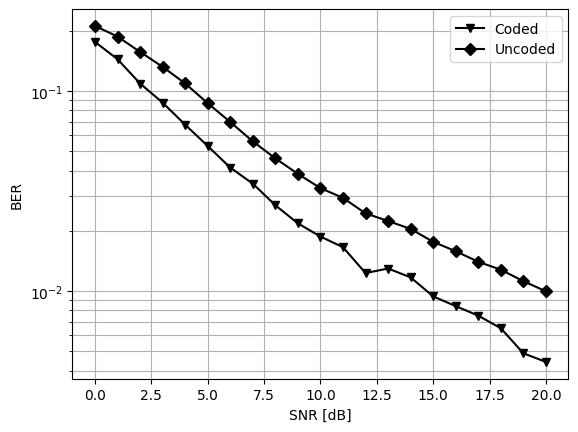

In [6]:
# Plot

plt.figure()
plt.semilogy(snr_db, BER_coded, "v-", label="Coded", color="black")
plt.semilogy(snr_db, BER_uncoded, "D-", label="Uncoded", color="black")
ber = (1/2)*erfc(np.sqrt(10**(0.1*snr_db)/2))
#plt.plot(snr_db, ber, label="AWGN", color="black")
plt.xlabel("SNR [dB]")
plt.ylabel("BER")
plt.xscale("linear")
plt.yscale("log")
plt.grid(which="both")
plt.legend()
#plt.xlim([0, 15])
#plt.ylim([10**(-8), 0.5])
plt.show()

In [6]:
# Load interferences

interrference_ratio = np.load("data/ratio_power_interf_obstacles.npy")

In [10]:

ebn0 = np.arange(0, 21, 1) #dB
snr_db = ebn0 + 10*np.log10(tx_params["codingRate"]) + 10*np.log10(nmodbits) #dB
nb_seq =300
alpha = 0

BER_coded = np.zeros(len(ebn0))
BER_uncoded = np.zeros(len(ebn0))

BER_coded_all = np.zeros((len(ebn0), nb_seq))
BER_uncoded_all = np.zeros((len(ebn0), nb_seq))
SINR_all = np.zeros((len(ebn0), nb_seq))

gn = np.array([1, 1])
gd = np.array([1, 1, 1])
R1,R0,out_R1,out_R0 = poly2trellis(gn,gd)
d = 1
out_R1_tf = tf.convert_to_tensor(out_R1)
out_R0_tf = tf.convert_to_tensor(out_R0)
symb_R1 = mapper(out_R1_tf).numpy()
symb_R0 = mapper(out_R0_tf).numpy()

for ii in range(len(snr_db)) :

  BER_coded_ii = np.zeros(nb_seq)
  BER_uncoded_ii = np.zeros(nb_seq)

  var_noise = 1/(10**(0.1*snr_db[ii]))
  len_b = tx_params["kCode"]

  for jj in range(nb_seq) :

    # NOMA Power allocation
    Ptot_db = 10 # total power allocation in dB
    Ptot = 10**(0.1*Ptot_db)
    #polynomial = np.array([1, 3, 3, -1*Ptot/var_noise])
    polynomial = np.array([1, 2, 1, -1*Ptot])
    roots = np.roots(polynomial) # roots of polynomial
    x = roots[np.isreal(roots)][-1] # keep only real root

    #Evaluate the root 
    #print(polynomial[0]*x**3 + polynomial[1]*x**2 + polynomial[2]*x + polynomial[3]	)

    if(len(roots[np.isreal(roots)])>1) : 
      print("More than 2 roots found in polynomial")

    tx_params["powerAllocation"] = get_power_allocation(tx_params, Ptot, var_noise)

    data = np.zeros((tx_params["nUsers"], tx_params["nCode"])) # nCode noramlement (à changer après)
    b = binary_source([tx_params["nUsers"], tx_params["kCode"]])
    #c = encoder(b)
    # encoding
    b_array = b.numpy()
    c_array = np.zeros((tx_params["nUsers"], 2*len(b_array[0])))
    for idx_user in range(tx_params["nUsers"]):
      (u_s,u_c) = conv_encoder(b_array[idx_user],R1,R0,out_R1,out_R0,len_b)
      c_array[idx_user] = np.reshape(np.transpose([u_s,u_c]),(2*len(u_s),))
    c = tf.convert_to_tensor(c_array)
    #c=b 
    x = mapper(c)
    data = x.numpy()

    data_out = NOMA(data, tx_params)
    
    h = Rayleigh_canal(alpha, len(data_out))
    n = (1j*np.random.normal(scale=np.sqrt(var_noise/2), size=data_out.shape)+np.random.normal(scale=np.sqrt(var_noise/2),  size=data_out.shape))

    # Pick a random value from interference 
    interference = 1/np.random.choice(interrference_ratio, size=h.shape)
    y_canal = h*data_out+n+interference*Ptot

    # Reception 
    #y_canal = y_canal.reshape(1, len(y_canal))
    y_received = y_canal/h
    #y_received = y_canal
    y_decoded = np.zeros((tx_params["nUsers"], tx_params["kCode"]))
    y_demapped = np.zeros((tx_params["nUsers"], tx_params["nCode"])) # nCode noramlement (à changer après)
    # SIC 
    for idx_user in range(tx_params["nUsers"]):

      y = demapper([tf.convert_to_tensor(y_received), var_noise])
      y_demapped[idx_user, :] = y.numpy()

      #y_user = decoder(tf.convert_to_tensor(y.numpy().reshape((1, tx_params["nCode"]))))
      y_user = viterbi_decoder(R1,R0,symb_R1, symb_R0,len_b, y_received)
      #y_user = tf.convert_to_tensor(y.numpy().reshape((1, len(y))))

      y_decoded[idx_user, :] = y_user#.numpy()

      #y_user_encoded = encoder(y_user)
      (u_s,u_c) = conv_encoder(y_user,R1,R0,out_R1,out_R0,len_b)
      y_user_encoded = np.reshape(np.transpose([u_s,u_c]),(2*len(u_s),))
      y_user_encoded = tf.convert_to_tensor(y_user_encoded.reshape((1, len(y_user_encoded))))
    
      y_received = y_received - mapper(y_user_encoded).numpy()[0]*np.sqrt(tx_params["powerAllocation"][idx_user])

    y_demapped_tf = tf.convert_to_tensor(y_demapped)
    y_decoded_tf = tf.convert_to_tensor(y_decoded)
    c_hat = tf.cast(tf.less(0.0, y_demapped_tf), tf.double)
    b_hat = tf.cast(tf.less(0.0, y_decoded_tf), tf.float32)
    ber_uncoded = sionna.utils.metrics.compute_ber(c, c_hat)
    ber_coded = sionna.utils.metrics.compute_ber(b, b_hat)

    BER_coded_ii[jj] = ber_coded.numpy()
    BER_uncoded_ii[jj] = ber_uncoded.numpy()

    SINR_all[ii, jj] = Ptot/np.mean((interference*Ptot + var_noise))
    BER_coded_all[ii, jj] = ber_coded.numpy()
    BER_uncoded_all[ii, jj] = ber_uncoded.numpy()
  
  BER_coded[ii] = np.mean(BER_coded_ii)
  BER_uncoded[ii] = np.mean(BER_uncoded_ii)

  print("Eb/N0 = " + str(ebn0[ii]) +  "dB, BER uncoded = " +  str(BER_uncoded[ii]) + ", BER coded = " + str(BER_coded[ii]))
  

Eb/N0 = 0dB, BER uncoded = 0.35407407407407415, BER coded = 0.3973333333333333
Eb/N0 = 1dB, BER uncoded = 0.3509259259259259, BER coded = 0.3943703703703703
Eb/N0 = 2dB, BER uncoded = 0.3468425925925926, BER coded = 0.39146296296296296
Eb/N0 = 3dB, BER uncoded = 0.3410925925925926, BER coded = 0.3884814814814815
Eb/N0 = 4dB, BER uncoded = 0.3365740740740741, BER coded = 0.3902962962962963
Eb/N0 = 5dB, BER uncoded = 0.33214814814814814, BER coded = 0.3887407407407407
Eb/N0 = 6dB, BER uncoded = 0.3246203703703704, BER coded = 0.38785185185185184
Eb/N0 = 7dB, BER uncoded = 0.32143518518518516, BER coded = 0.3847962962962963
Eb/N0 = 8dB, BER uncoded = 0.3189814814814815, BER coded = 0.38425925925925924
Eb/N0 = 9dB, BER uncoded = 0.31392592592592594, BER coded = 0.3792037037037037
Eb/N0 = 10dB, BER uncoded = 0.3164907407407408, BER coded = 0.38557407407407407
Eb/N0 = 11dB, BER uncoded = 0.3153148148148148, BER coded = 0.3817962962962963
Eb/N0 = 12dB, BER uncoded = 0.3135833333333334, BER co

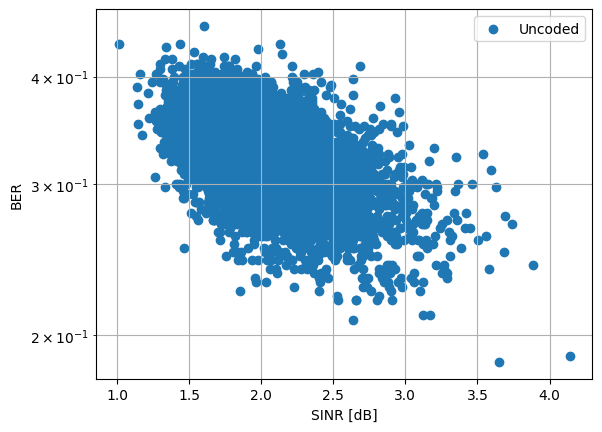

In [16]:
# Plot

plt.figure()
#plt.semilogy(snr_db, BER_coded, "v-", label="Coded", color="black")
#plt.semilogy(snr_db, BER_uncoded, "D-", label="Uncoded", color="black")
# Sort SINR_all.flatten() and sort BER_uncoded.flatten() according to SINR
idx = np.argsort(SINR_all.flatten())
SINR_all = SINR_all.flatten()[idx]
BER_uncoded_all = BER_uncoded_all.flatten()[idx]
plt.scatter(SINR_all, BER_uncoded_all, marker='o', label="Uncoded")
ber = (1/2)*erfc(np.sqrt(10**(0.1*snr_db)/2))
#plt.plot(snr_db, ber, label="AWGN", color="black")
plt.xlabel("SINR [dB]")
plt.ylabel("BER")
plt.xscale("linear")
plt.yscale("log")
plt.grid(which="both")
plt.legend()
#plt.xlim([0, 15])
#plt.ylim([10**(-8), 0.5])
plt.show()

In [17]:

ebn0 = np.arange(0, 21, 1) #dB
snr_db = ebn0 + 10*np.log10(tx_params["codingRate"]) + 10*np.log10(nmodbits) #dB
nb_seq =300
alpha = 0

BER_coded = np.zeros(len(ebn0))
BER_uncoded = np.zeros(len(ebn0))

gn = np.array([1, 1])
gd = np.array([1, 1, 1])
R1,R0,out_R1,out_R0 = poly2trellis(gn,gd)
d = 1
out_R1_tf = tf.convert_to_tensor(out_R1)
out_R0_tf = tf.convert_to_tensor(out_R0)
symb_R1 = mapper(out_R1_tf).numpy()
symb_R0 = mapper(out_R0_tf).numpy()

for ii in range(len(snr_db)) :

  BER_coded_ii = np.zeros(nb_seq)
  BER_uncoded_ii = np.zeros(nb_seq)

  var_noise = 1/(10**(0.1*snr_db[ii]))
  len_b = tx_params["kCode"]

  for jj in range(nb_seq) :

    # NOMA Power allocation
    Ptot_db = 10 # total power allocation in dB
    Ptot = 10**(0.1*Ptot_db)
    #polynomial = np.array([1, 3, 3, -1*Ptot/var_noise])
    polynomial = np.array([1, 2, 1, -1*Ptot])
    roots = np.roots(polynomial) # roots of polynomial
    x = roots[np.isreal(roots)][-1] # keep only real root

    #Evaluate the root 
    #print(polynomial[0]*x**3 + polynomial[1]*x**2 + polynomial[2]*x + polynomial[3]	)

    if(len(roots[np.isreal(roots)])>1) : 
      print("More than 2 roots found in polynomial")

    tx_params["powerAllocation"] = get_power_allocation(tx_params, Ptot, var_noise)

    data = np.zeros((tx_params["nUsers"], tx_params["nCode"])) # nCode noramlement (à changer après)
    b = binary_source([tx_params["nUsers"], tx_params["kCode"]])
    #c = encoder(b)
    # encoding
    b_array = b.numpy()
    c_array = np.zeros((tx_params["nUsers"], 2*len(b_array[0])))
    for idx_user in range(tx_params["nUsers"]):
      (u_s,u_c) = conv_encoder(b_array[idx_user],R1,R0,out_R1,out_R0,len_b)
      c_array[idx_user] = np.reshape(np.transpose([u_s,u_c]),(2*len(u_s),))
    c = tf.convert_to_tensor(c_array)
    #c=b 
    x = mapper(c)
    data = x.numpy()

    data_out = NOMA(data, tx_params)
    
    h = Rayleigh_canal(alpha, len(data_out))
    n = (1j*np.random.normal(scale=np.sqrt(var_noise/2), size=data_out.shape)+np.random.normal(scale=np.sqrt(var_noise/2),  size=data_out.shape))

    # Pick a random value from interference 
    interference = 1/np.random.choice(interrference_ratio, size=h.shape)
    y_canal = h*data_out+n+interference*Ptot

    # Reception 
    #y_canal = y_canal.reshape(1, len(y_canal))
    y_received = mmse = MyMMSE(data_out, h, var_noise, y_canal)
    #y_received = y_canal
    y_decoded = np.zeros((tx_params["nUsers"], tx_params["kCode"]))
    y_demapped = np.zeros((tx_params["nUsers"], tx_params["nCode"])) # nCode noramlement (à changer après)
    # SIC 
    for idx_user in range(tx_params["nUsers"]):

      y = demapper([tf.convert_to_tensor(y_received), var_noise])
      y_demapped[idx_user, :] = y.numpy()

      #y_user = decoder(tf.convert_to_tensor(y.numpy().reshape((1, tx_params["nCode"]))))
      y_user = viterbi_decoder(R1,R0,symb_R1, symb_R0,len_b, y_received)
      #y_user = tf.convert_to_tensor(y.numpy().reshape((1, len(y))))

      y_decoded[idx_user, :] = y_user#.numpy()

      #y_user_encoded = encoder(y_user)
      (u_s,u_c) = conv_encoder(y_user,R1,R0,out_R1,out_R0,len_b)
      y_user_encoded = np.reshape(np.transpose([u_s,u_c]),(2*len(u_s),))
      y_user_encoded = tf.convert_to_tensor(y_user_encoded.reshape((1, len(y_user_encoded))))
    
      y_received = y_received - mapper(y_user_encoded).numpy()[0]*np.sqrt(tx_params["powerAllocation"][idx_user])

    y_demapped_tf = tf.convert_to_tensor(y_demapped)
    y_decoded_tf = tf.convert_to_tensor(y_decoded)
    c_hat = tf.cast(tf.less(0.0, y_demapped_tf), tf.double)
    b_hat = tf.cast(tf.less(0.0, y_decoded_tf), tf.float32)
    ber_uncoded = sionna.utils.metrics.compute_ber(c, c_hat)
    ber_coded = sionna.utils.metrics.compute_ber(b, b_hat)

    BER_coded_ii[jj] = ber_coded.numpy()
    BER_uncoded_ii[jj] = ber_uncoded.numpy()
  
  BER_coded[ii] = np.mean(BER_coded_ii)
  BER_uncoded[ii] = np.mean(BER_uncoded_ii)

  print("Eb/N0 = " + str(ebn0[ii]) +  "dB, BER uncoded = " +  str(BER_uncoded[ii]) + ", BER coded = " + str(BER_coded[ii]))
  

KeyboardInterrupt: 